# Forecasting with sktime

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.


<img src="img/forecasting.png" width=750 />

For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

## Data
For this tutorial, we will use the famous Box-Jenkins airline data set, which shows the number of international airline
passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

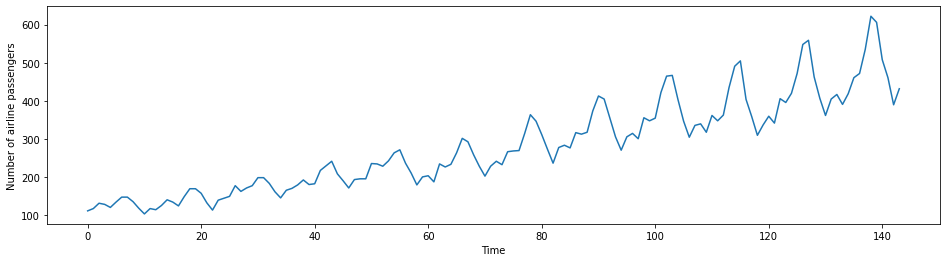

In [2]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

## Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

108 36


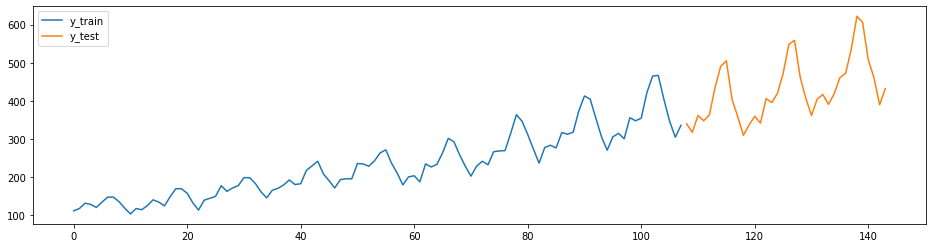

In [3]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm. We can specify the forecasting horizon as a simple numpy array of the steps ahead, relative to the end of the training series:

In [4]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead.

Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

```python
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

## Forecasting

Like in scikit-learn, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.

1. We always predict the last value observed (in the training series),
2. We predict the last value observed in the same season.

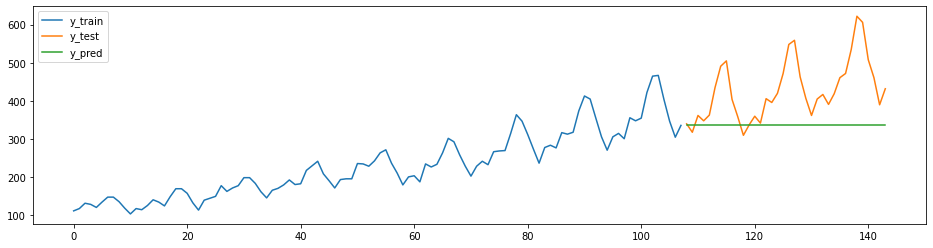

In [5]:
# we can do that with a few lines of code
y_pred = np.repeat(y_train.iloc[-1], len(fh))
y_pred = pd.Series(y_pred, index=y_train.index[-1] + fh)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

0.23195770387951434

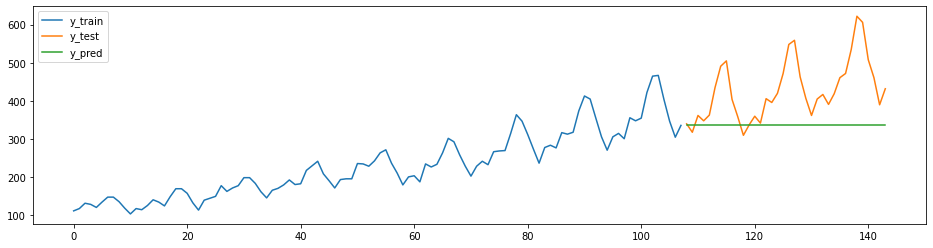

In [6]:
# using sktime 

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_last = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_last, y_test)

0.145427686270316

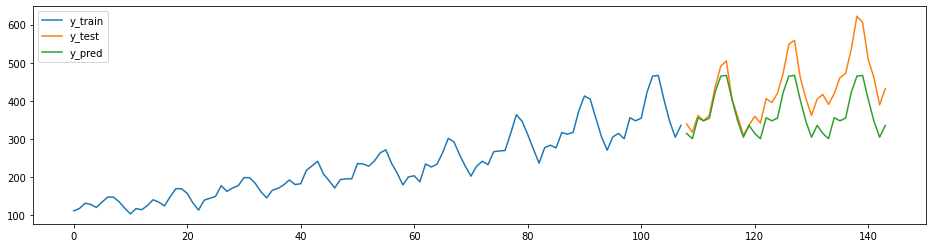

In [7]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

## But can I not just use scikit-learn?

In principle, yes, but many pitfalls ...

### Pitfall 1: model validation

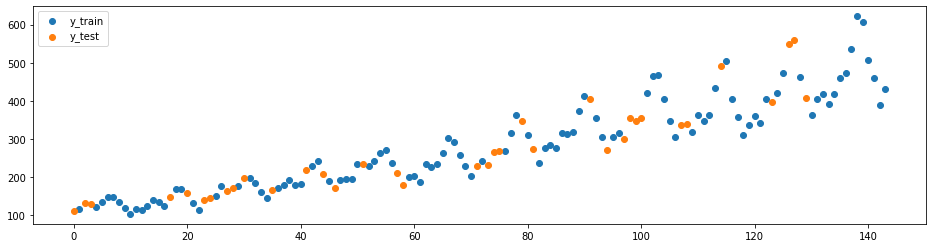

In [8]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y)
plot_ys(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

This leads to leakage: 

> The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

But `train_test_split(y, shuffle=False)` works, which is what `temporal_train_test_split(y)` does in sktime:

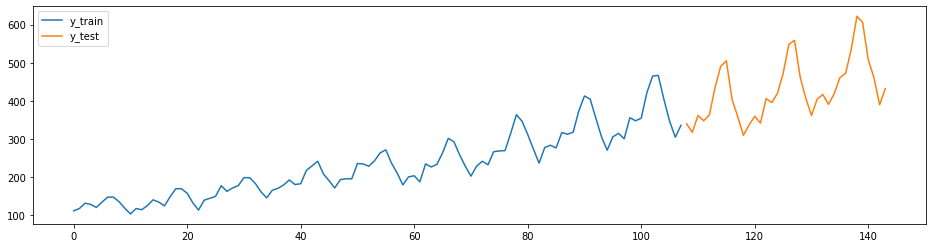

In [9]:
y_train, y_test = temporal_train_test_split(y)
plot_ys(y_train, y_test, labels=["y_train", "y_test"]);

### Pitfall 2: how to apply regression algorithms?

In order to use scikit-learn, we have to first transform the data into the required tabular format, then fit a regressor and finally generate forecasts. 

#### Reduction: from forecasting to regression
Forecasting is often solved via regression. This approach is sometimes called reduction, because we reduce the forecasting task to the simpler but related task of tabular regression. This allows to apply any regression algorithm to the forecasting problem.

Reduction to regression works as follows: We first need to transform the data into the required tabular format. We can do this by cutting the training series into windows of a fixed length and stacking them on top of each other. Our target variable consists of the subsequent observation for each window.

We could write some code to do that, as for example in the [M4 competition](https://github.com/Mcompetitions/M4-methods):

In [10]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets. Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num):]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
#     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features] (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [11]:
# here we split the time index, rather than the actual values, to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(y.index.values, 10, len(fh))

In [12]:
feature_window[:5, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [13]:
target_window[:5]

array([10, 11, 12, 13, 14])

In [14]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

(98, 10) (98,)


In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

What are potential pitfalls here?

> This requires a lot of hand-written code which is often error-prone, not modular and not tuneable. 

> Note also that these steps involve a number of implicit hyper-parameters:
* the way you slice the time series into windows (e.g. the window length)
* the way you generate forecasts (recursive strategy, direct strategy, other hybrid strategies)

### Pitfall 3: how to generate forecasts?

In [16]:
print(x_test.shape, y_test.shape)

# add back time index to y_test 
y_test = pd.Series(y_test, index=y.index[-len(fh):])

(36, 10) (36,)


In [17]:
y_pred = model.predict(x_test)
smape_loss(pd.Series(y_pred, index=y_test.index), y_test)

0.11317036857314437

But what's the problem here?

> We actually don't make a multi-step-ahead forecast up to the 36th step ahead. Instead, we make 36 single-step-ahead forecasts always using the most recent data. But that's a solution to a different learning task! 

To fix this problem, we could write some code to do this recursively as in the M4 competition:

In [18]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)
    
    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction
    
    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)
smape_loss(y_pred_rec, y_test)

0.15401455736842518

## Forecasting with sktime

### Reduction: from forecasting to regression

sktime provides a meta-estimator for this approach, which is: 
* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **tuneable**, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

<img src="img/forecasting-to-regression-reduction.png" />

In [19]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14008272913734346

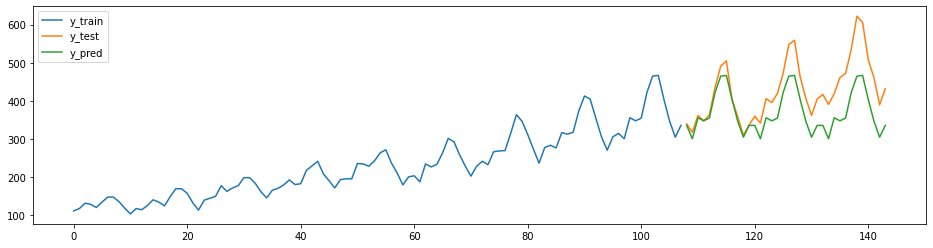

In [20]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

To better understand the prior data transformation, we can look at how we can split the training series into windows. Internally, sktime uses a temporal time series splitter, similar to the cross-validation splitter in scikit-learn. Here we show how this works for the first 20 observations of the training series:

In [21]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train.iloc[:20]):
    print(input_window, output_window)

[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]


### Statistical forecasters

sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.

Note that since this is monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

/Users/Hongyi/Documents/GitHub/sktime/sktime/forecasting/exp_smoothing.py:99: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  seasonal_periods=self.sp,
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:1136: FutureWarning: use_basinhopping is deprecated. Set optimization method using 'method'. This option will be removed after 0.13 is released.
  FutureWarning,


0.05144409835065696

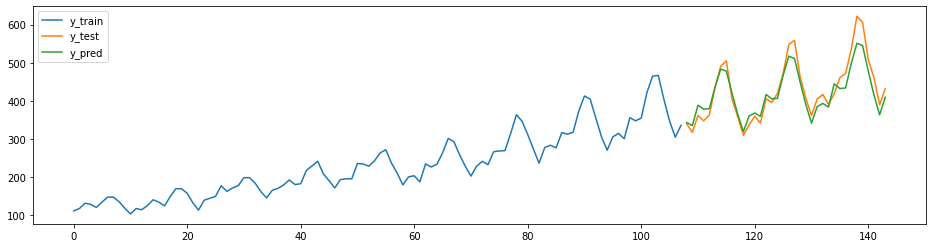

In [22]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

The exponential smoothing of state space model can also be automated similar to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R.

In [ ]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(autofitting=True,sp=12,n_jobs=-1,allow_multiplicative_trend=True)
forecaster.fit(y_train.astype('float64'))
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Another common model is the ARIMA model. In sktime, we interface [pmdarima](https://github.com/alkaline-ml/pmdarima), a package for automatically selecting the best ARIMA model. This since searches over a number of possible model parametrisations, it may take a bit longer.

In [ ]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Compositite model building

sktime provides a modular API for composite model building for forecasting.

### Ensembling
Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## Tuning
In the `ReducedRegressionForecaster`, both the `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise.

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

In [ ]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
gscv.best_params_

Using scikit-learn's `GridSearchCV`, we can tune regressors imported from scikit-learn, in addition to tuning `window_length`.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import RecursiveRegressionForecaster

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

To access performance on a particular metric during tuning, we can use the `scoring` argument of `ForecastingGridSearchCV`.

In [ ]:
from sktime.performance_metrics.forecasting import sMAPE

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE())
gscv.fit(y_train)
print(gscv.cv_results_)

### Detrending
Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

In [ ]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

## Dynamic forecasts

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, all forecasters in sktime have a `update_predict` method. Here we make repeated single-step ahead forecasts over the test set.

Note that the forecasting task is changed: while we still make 36 predictions, we do not predict 36 steps ahead, but instead make 36 single-step-ahead predictions.

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_ys(y_train, y_test, y_pred);

For a single update, you can use the `update` method.

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

In [ ]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();

## Summary

As we have seen, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon. 

* sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

* sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the currently running [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).